##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

# Dogs vs Cats Image Classification With Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/148B0g-zaefmDTWxbEk1OiKGCEPojWwgz"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="Link to be updated"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub link to be updated accordingly</a>
  </td>
</table>



In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using `Layer` and load data by creating training and validation tensors of images as well as their corresponding labels.

## Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts:

* Building _data input pipelines_  — How can we efficiently work with data on disk to interface with our model? 
* _Overfitting_ - what is it, how to identify it?
* _Data Augmentation_ and _Dropout_ -  Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model. 

## We will follow the general machine learning workflow:

1. Examine and understand data
2. Build an input pipeline 
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

<hr>


**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. If you have been working through several notebooks, this will help you avoid reaching Colab's memory limits.



# Importing packages

Let's start by importing required packages:

*   glob — to read files and directory structure.
*   numpy — for some matrix math outside of TensorFlow.
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data.
*  PIL — to view images.

In [0]:
import TensorFlow
import Foundation
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let np = Python.import("numpy")  // Make numpy available using np.
let subprocess = Python.import("subprocess")
let plt = Python.import("matplotlib.pyplot")
let os = Python.import("os")
let glob = Python.import("glob")
let pil = Python.import("PIL")
let pilImageOps = Python.import("PIL.ImageOps")
let random = Python.import("random")
let sk = Python.import("skimage")

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of the <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In this Colab, we will make use of the `glob` and  `subprocess` module which will read data from disk. We therefore need to directly download *Dogs vs. Cats* from a URL and unzip it to the Colab filesystem.

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [0]:
print("/bin/ls".shell("-lh"))

total 4.0K
drwxr-xr-x 1 root root 4.0K Aug  2 16:06 sample_data



We'll now download and unzip the dataset using the `subprocess` library via Python interoperability.

In [0]:
let command = "wget -nv -O- https://github.com/Ayush517/S4TF-Tutorials/raw/master/cats_and_dogs_filtered.tar.gz | tar xzf - -C ."
subprocess.call(command, shell: true)

2019-08-08 01:32:41 URL:https://raw.githubusercontent.com/Ayush517/S4TF-Tutorials/master/cats_and_dogs_filtered.tar.gz [67304034/67304034] -> "-" [1]


0


The dataset we have downloaded has the following directory structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [0]:
print("/bin/ls/".shell("-lh"))

total 8.0K
drwxr-x--- 4  501 staff 4.0K Sep 23  2016 cats_and_dogs_filtered
drwxr-xr-x 1 root root  4.0K Aug  2 16:06 sample_data



### Understanding our data

We'll now assign variables with the proper file path for the training and validation sets.

In [0]:
let catTrainList = glob.glob("cats_and_dogs_filtered/train/cats/*.jpg")
let dogTrainList = glob.glob("cats_and_dogs_filtered/train/dogs/*.jpg")
let trainList = glob.glob("cats_and_dogs_filtered/train/**/*.jpg")

let catTestList  = glob.glob("cats_and_dogs_filtered/validation/cats/*.jpg")
let dogTestList  = glob.glob("cats_and_dogs_filtered/validation/dogs/*.jpg")
let testList  = glob.glob("cats_and_dogs_filtered/validation/**/*.jpg")

for i in 0 ..< 5 {
    np.random.shuffle(trainList)
    np.random.shuffle(testList)
}

Let's look at how many cats and dogs images we have in our training and validation directory:

In [0]:
print("total training cat images: \(catTrainList.count)")
print("total training dog images: \(dogTrainList.count)")

print("total validation cat images: \(catTestList.count)")
print("total validation dog images: \(dogTestList.count)")
print("--")
print("Total training images: \(trainList.count)")
print("Total validation images: \(testList.count)")

print(Python.type(trainList))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000
<class 'list'>


### Visualizing Training images

We can visualize our training images by creating functions to plot images through their paths or tensors, and then plotting a few of them.

In [0]:
func plotImages(_ image: Tensor<Float>) {
    let numpyImage = image.reshaped(to: [150, 150, 3]).makeNumpyArray()
    plt.imshow(numpyImage)
    plt.show()
}

func plotImages(fromPath path: String) {
    let img = pil.Image.open(path)
    let image = np.array(img) * (1.0 / 255)
    plt.imshow(image)
    plt.show()
}

# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In Swift for TensorFlow we can implement this using the different Python libraries through Python interoperability. We can simply apply different transformations we would want to our dataset images and they will be applied during our training process.

We perform the following image augmentation techniques randomly on an image:

* Rotating the image
* Transposing
* Cropping
* Flipping the image horizontally
* Adding border to image
* Adding noise

In [0]:
func augmentedImage(path: String) -> Tensor<Float> {
    
    var img = pil.Image.open(path)
    
    if random.random() < 0.5 {
        img = img.rotate(45) // Rotate 45 degrees.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.TRANSPOSE) // Transpose.
    }
    
    if random.random() < 0.5 {
        let h = Float(img.size[0])! / 4
        let w = Float(img.size[1])! / 4
        let cropBorder = Int(Python.min(h, w))
        img = pilImageOps.crop(img,  cropBorder) // Crop by half of shorter sides.
    }
    
    if random.random() < 0.5 {
        img = img.transpose(pil.Image.FLIP_LEFT_RIGHT) // Flip.
    }
    
    if random.random() < 0.5 {
        let h = Float(img.size[0])! / 10
        let w = Float(img.size[1])! / 10
        let borderSize = Int(Python.min(h, w))
        img = pilImageOps.expand(img, borderSize) // Add border.
    }
    
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    
    if random.random() < 0.5 {
        image = sk.util.random_noise(image) // Add noise.
    }
    
    image = np.array(image, dtype: np.float32)
    
    let imageTensor = Tensor<Float>(numpy: image)!

    return imageTensor
}

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk.
2. Decode the contents of these images into their RGB bytes.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, to better match the range expected by the initial neural network weights.
5. Apply or don't apply image augmentation techniques, based on the type of data.

We have done this in the following code.

The `resizedImage(fromPath:augmented:)` function takes 2 inputs:
1. Image path as input.
2. Whether or not to apply image augmentations.

The `images(fromList:imageCount:augmented:)` function takes 3 inputs :

1. List of paths.

2. Number of tensors to be produced in the output tensor as input.

3. Whether or not to apply image augmentations.

In [0]:
func resizedImage(fromPath: String, augmented: Bool) -> (Tensor<Float>, Int32) {
    var img = pil.Image.open(fromPath)
    var image = np.array(img, dtype: np.float32) * (1.0 / 255)
    var imageTensor = Tensor<Float>(numpy: image)!
    
    if augmented {
        imageTensor = augmentedImage(path: fromPath)
    }
    
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = Raw.resizeArea(images: imageTensor , size: [150, 150])
    
    let label: Int32 = fromPath.contains("dog.") ? 0 : 1
    
    return (imageTensor, label)
}

func images(fromList: PythonObject, imageCount: Int, augmented: Bool) -> (image: Tensor<Float>, label: Tensor<Int32>) {
    let batchFiles = fromList[0..<imageCount]
    var labels: [Int32] = []
    var x: Tensor<Float>
    var y: Tensor<Int32>

    // Load first image.
    let path = String(batchFiles[0]) ?? ""
    let data = resizedImage(fromPath: path, augmented: augmented)
    x = data.0 
    labels.append(data.1)

    // Load rest of the images.
    var numberOfFilesDone = 1
    for file in batchFiles[1..<imageCount] {
        let path = String(file) ?? ""
        let data = resizedImage(fromPath: path, augmented: augmented)
        let tensor = data.0
        labels.append(data.1)
        x = Tensor(concatenating: [x, tensor], alongAxis: 0)
    }
    y = Tensor<Int32>(labels)
    return (x, y)
}

After defining our generators for images and labels, we will load those images and labels in tensor arrays, thereby creating our `testTensors`.

In [0]:
let testTensors = images(fromList: testList, imageCount: testList.count, augmented: false)
let testImageTensors = testTensors.0
let testLabelTensors = testTensors.1
print(testImageTensors.shape)
print(testLabelTensors.shape)

[1000, 150, 150, 3]
[1000]


# Model Creation

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. This mean that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [0]:
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1c = Conv2D<Float>(filterShape: (3, 3, 64, 128), activation: relu)
    var pool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var conv1d = Conv2D<Float>(filterShape: (3, 3, 128, 128), activation: relu)
    var pool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    
    var dropout1a = Dropout<Float>(probability: 0.5)
    var flatten = Flatten<Float>()
    var layer1a = Dense<Float>(inputSize: 6272, outputSize: 512, activation: relu)
    var layer1b = Dense<Float>(inputSize: 512, outputSize: 2, activation: softmax)

    @differentiable
    public func callAsFunction(_ input: Input) -> Output {
        var convolved1 = input.sequenced(through: conv1a, pool1)
        var convolved2 = convolved1.sequenced(through: conv1b, pool2)
        var convolved3 = convolved2.sequenced(through: conv1c, pool3)
        var convolved4 = convolved3.sequenced(through: conv1d, pool4)
        return convolved4.sequenced(through: dropout1a, flatten, layer1a, layer1b)
    }
}

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `softmaxCrossEntropy` as the loss function. We would also like to look at the training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [0]:
let tensor = Tensor<Float>(zeros: [1, 150, 150, 3])
var classifier = Classifier()
var optimizer = Adam(for: classifier)
classifier(tensor).shape

▿ [1, 2]
  ▿ dimensions : 2 elements
    - 0 : 1
    - 1 : 2


In [0]:
let epochCount = 100
let batchSize = 100

// Extract a batch of size batchSize.
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start + batchSize]
}

In [0]:
var trainingAccuracy: [Float] = []
var validationAccuracy: [Float] = []
var trainingLoss: [Float] = []
var validationLoss: [Float] = []
var epochsRange: [Int] = []

### Train the model

It's time to train our network. 

 We need to apply the random image augmentations every time an image is accessed, so we recreate `trainTensors` in every epoch.

In [0]:
print("Beginning training...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    epochsRange.append(epoch)
    var trainStats = Statistics()
    var testStats = Statistics()
    print("Creating Training Dataset for Epoch \(epoch)")
    let trainTensors = images(fromList: trainList, imageCount: trainList.count, augmented: true)
    let trainImageTensors = trainTensors.0
    let trainLabelTensors = trainTensors.1
    print("Dataset Creation Completed")
    
    Context.local.learningPhase = .training
    for i in 0..<Int(trainList.count) / batchSize {
        let x = minibatch(in: trainImageTensors, at: i)
        let y = minibatch(in: trainLabelTensors, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier.allDifferentiableVariables, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0..<Int(testList.count) / batchSize {
        let x = minibatch(in: testImageTensors, at: i)
        let y = minibatch(in: testLabelTensors, at: i)
        // Compute loss on test set.
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }
    
    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    
    trainingAccuracy.append(trainAccuracy)
    validationAccuracy.append(testAccuracy)
    trainingLoss.append(trainStats.totalLoss)
    validationLoss.append(testStats.totalLoss)
    
    print("""
          [Epoch \(epoch)] \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

Beginning training...
Creating Training Dataset for Epoch 1
Dataset Creation Completed
[Epoch 1] Training Loss: 14.008552, Training Accuracy: 1003/2000 (0.5015), Test Loss: 6.9179916, Test Accuracy: 500/1000 (0.5)
Creating Training Dataset for Epoch 2
Dataset Creation Completed
[Epoch 2] Training Loss: 13.857941, Training Accuracy: 1023/2000 (0.5115), Test Loss: 6.9059653, Test Accuracy: 500/1000 (0.5)
Creating Training Dataset for Epoch 3
Dataset Creation Completed
[Epoch 3] Training Loss: 13.827478, Training Accuracy: 1023/2000 (0.5115), Test Loss: 6.8789077, Test Accuracy: 543/1000 (0.543)
Creating Training Dataset for Epoch 4
Dataset Creation Completed
[Epoch 4] Training Loss: 13.689729, Training Accuracy: 1096/2000 (0.548), Test Loss: 6.7599926, Test Accuracy: 595/1000 (0.595)
Creating Training Dataset for Epoch 5
Dataset Creation Completed
[Epoch 5] Training Loss: 13.692575, Training Accuracy: 1121/2000 (0.5605), Test Loss: 6.723502, Test Accuracy: 579/1000 (0.579)
Creating Train

### Visualizing results of the training

We'll now visualize the results we get after training our network.

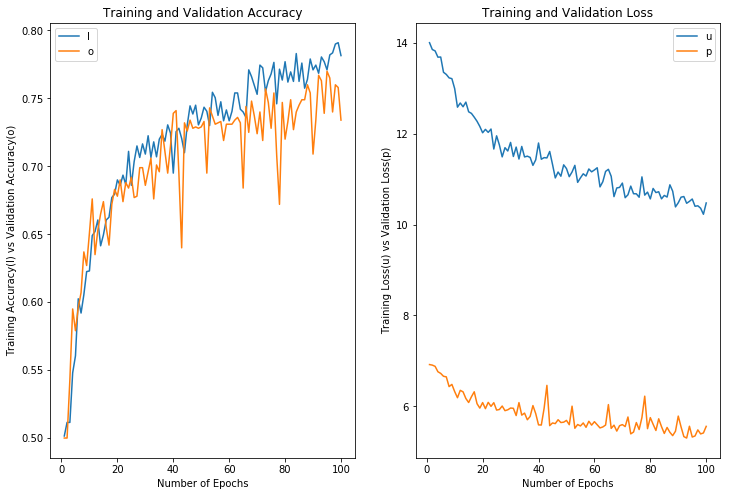

None


In [0]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot(epochsRange, trainingAccuracy)
plt.plot(epochsRange, validationAccuracy)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(epochsRange, trainingLoss)
plt.plot(epochsRange, validationLoss)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by a much smaller margin than what we saw in Tutorial 5 and our model has achieved around **73%** accuracy on the validation set with a training accuracy of **78%** (depending on the number of epochs you trained for).

This is a clear indication that we have prevented overfitting by performing image augmentation techniques on our training images.